# Implement V subtraction method

### Apr 6, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")
import time

## Aux. functions

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

## Expected polarization 

In [19]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

# Soft triggers distribution

In [20]:
wf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/DPulseWforms_run012611_allDepths.pkl")
# softWf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/SoftTrigWforms_run012559.pkl")
wf = wf.loc[wf.theta_reco>=90]

### Add interpolated depth to df

In [31]:
depth_1229 = pd.read_csv("./plots/SpiceCorePolReco/A2_1229Depth.txt")
time = pd.to_datetime(depth_1229.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=29, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [32]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1229.depth,bounds_error=False, fill_value=0.)
# wf = wf.loc[(wf.unixTime>min(wf.unixTime)) & (wf.unixTime<2.15*1E4+1.5456*1E9)]
# softWf = softWf.loc[(softWf.unixTime>min(wf.unixTime)) & (softWf.unixTime<2.15*1E4+1.5456*1E9)]

interp_depth = f(wf.unixTime)
# interp_depthSoft = f(softWf.unixTime)

wf["interp_depth"] = interp_depth
# softWf["interp_depth"] = interp_depthSoft

In [34]:
wf.interp_depth

1       1142.000000
2       1135.500000
3       1134.833333
4       1134.500000
5       1133.666667
           ...     
2553     346.875000
2554     346.250000
2555     345.416667
2556     344.791667
2557     343.541667
Name: interp_depth, Length: 1569, dtype: float64

In [35]:
def calculatePower(t, v):
    dT = t[1]-t[0]
    power = np.sum(v**2)*dT
    return power

In [36]:
wf.columns

Index(['evNum', 'ch0Wf', 'ch1Wf', 'ch2Wf', 'ch3Wf', 'ch4Wf', 'ch5Wf', 'ch6Wf',
       'ch7Wf', 'ch8Wf', 'ch9Wf', 'ch10Wf', 'ch11Wf', 'ch12Wf', 'ch13Wf',
       'ch14Wf', 'ch15Wf', 'times', 'theta_reco', 'phi_reco', 'unixTime',
       'interp_depth'],
      dtype='object')

In [37]:
# wf = wf.drop(columns=['evNum','theta_reco', 'phi_reco', 'unixTime'])
wf

,evNum,ch0Wf,ch1Wf,ch2Wf,ch3Wf,ch4Wf,ch5Wf,ch6Wf,ch7Wf,ch8Wf,...,ch11Wf,ch12Wf,ch13Wf,ch14Wf,ch15Wf,times,theta_reco,phi_reco,unixTime,interp_depth
1,5698,"[23.212790984349784, 46.01801462120953, 13.763...","[-37.94826970904755, 40.671615208374064, 97.81...","[-148.26684025441895, -153.23772005810352, -25...","[-69.50610317184528, -51.55386746840601, 36.01...","[-32.56591089761726, 94.57179902768482, 115.12...","[70.79536431601043, 50.960373158861444, -33.09...","[127.86287139711183, 95.43282592078818, 33.873...","[0.7390379719936186, -85.89528553491475, -139....","[-47.55598335846651, -291.6574967572872, -248....",...,"[35.20774757617964, -59.72203336149784, -80.28...","[-99.99729733713824, -94.41274687237281, 87.82...","[-117.78239269976511, -83.82470735680145, -11....","[-58.890725450824725, -224.30815167900917, -24...","[-113.80983804280297, -190.95834101889233, -15...","[56.46902313679705, 56.96902313679705, 57.4690...",114.0,253.0,1546059828,1142.000000
2,5872,"[35.597791598482814, -0.880975030511886, -37.6...","[-104.09124616221332, -100.25765289509698, -40...","[240.3431957907339, 37.175691971622676, -166.1...","[87.98195252777967, 26.639143289689223, -43.15...","[-110.40133413815639, 5.506085174853232, 151.1...","[-102.37151691321489, -45.50257093558912, 61.1...","[40.70514827967156, 25.753290844246674, 18.883...","[156.14450421089754, 150.6633784962117, 35.203...","[-47.15868960886527, -66.40214171569785, -74.7...",...,"[39.55008702245418, -16.446925601630024, -117....","[59.66848014070435, -133.75308426993942, -188....","[67.58573267296678, 45.11725159775674, -10.629...","[-303.42700496826, -258.54146972427327, -65.69...","[-3.42433352350948, 91.16725231843316, 77.2556...","[57.96902313679705, 58.46902313679705, 58.9690...",116.0,253.0,1546059867,1135.500000
3,5899,"[-2.5891271120936983, -70.3482472822312, -84.5...","[-96.23553539383342, -100.8381469461719, -40.7...","[312.8134549239279, 208.71379436556765, -103.8...","[-57.94668122552355, -43.07146091062694, 6.133...","[-38.72978785692989, -53.58747649952095, -18.1...","[18.974650670091783, -10.370346396554073, -34....","[-69.18658056945424, 227.7644946011229, 320.49...","[-93.53572242286651, -31.756660346031317, 22.1...","[-17.07634790648626, -54.778367730927954, -120...",...,"[168.51611483885145, 229.23494394776446, 134.8...","[64.69843195344856, -67.32532561776407, -140.0...","[-39.53203608953014, 25.575712724940086, 103.3...","[38.1116945665992, 59.37398264461015, 20.72798...","[286.44135304500657, 125.02199844345031, -179....","[72.46902313679705, 72.96902313679705, 73.4690...",115.0,254.0,1546059871,1134.833333
4,5916,"[28.315898810976556, -26.988965226277124, -52....","[88.89755148794536, 110.03561987855505, 38.559...","[8.357096394389401, 37.282808775167446, 2.7432...","[-85.2032795129965, -69.73894372933302, -29.28...","[-98.8529277050182, 67.0386238786546, 133.7605...","[12.203913847306586, -67.53533904713527, -93.3...","[153.90078874134645, 11.063555625101374, -123....","[12.53829771428967, -36.36332916051902, -16.90...","[77.5133218691099, 62.94109528830387, -42.8851...",...,"[125.13675145032674, -119.28718661313134, -238...","[-116.63872360997732, -44.03127753669941, 76.7...","[21.29914955051858, 23.98284115593369, -62.768...","[-213.52186000561906, -268.04716183866833, -19...","[-9.400120190379205, 146.17124220126942, 232.3...","[70.39507781669586, 70.89507781669586, 71.3950...",115.0,254.0,1546059873,1134.500000
5,5936,"[-15.792517934992782, -18.753173785924155, -19...","[-55.153277376625915, 96.0643267483343, 137.62...","[-8.793691012351484, 176.371603720507, 263.813...","[-3.453086811315157, 54.881114122215045, 69.88...","[-95.81773463093623, 45.86505573048017, 112.77...","[94.25631051919868, 107.33557442779171, 57.671...","[-110.31779511376085, 43.094245136281366, 236....","[99.78180757873695, -14.573056896043212, -117....","[-243.02159883287226, -188.9590345427711, 46.8...",...,"[-76.21025262536595, -41.38098549776126, 33.49...","[117.62489578740

In [38]:
power = []
# start = time.time()

for i in wf.itertuples():
    chanPow = []
    for chan in range(1,16):
        chanPow.append(calculatePower(wf.times[3],i[chan]))
    chanPow.append(i.interp_depth)
    chanPow.append(estimatePolRayTracer(i.interp_depth)[2])
    power.append(chanPow)
# end = time.time()
# print(end - start)

IndexError: list index out of range

In [39]:
chPowNames = ["ch%iPow"%i for i in range(15) ]
colNames = [*chPowNames, "depth", "rec_ang"] 
df = pd.DataFrame(power, columns = colNames)
# df.to_pickle("./data/noiseSubtractAmyMethod_run012559_allDepths.pkl")


In [40]:
df = df.loc[(df.depth<1100) & (df.depth>600)]

In [41]:
# df.rec_ang[len(df)-2]
# df.ch9Pow[1]
df

,ch0Pow,ch1Pow,ch2Pow,ch3Pow,ch4Pow,ch5Pow,ch6Pow,ch7Pow,ch8Pow,ch9Pow,ch10Pow,ch11Pow,ch12Pow,ch13Pow,ch14Pow,depth,rec_ang
42,25006592.0,1.913966e+07,3.930930e+07,4.476745e+07,2.578780e+07,3.016023e+07,2.166666e+07,3.253937e+07,2.406928e+07,2.320601e+06,1.477307e+06,1.328491e+06,1.530954e+06,1.264574e+06,1.533390e+06,1099.833333,107.591925
43,25098612.5,8.043817e+06,2.390661e+07,2.372835e+07,1.163873e+07,1.427211e+07,9.817464e+06,2.132727e+07,1.907680e+07,1.178904e+06,1.414777e+06,1.101397e+06,1.087985e+06,1.392321e+06,1.083649e+06,1099.500000,107.583703
44,25276050.0,1.670768e+07,3.194289e+07,3.083498e+07,2.202182e+07,2.874457e+07,2.077608e+07,2.591039e+07,2.960794e+07,1.640852e+06,1.925402e+06,1.892184e+06,1.722670e+06,1.528124e+06,8.524394e+05,1098.833333,107.567252
45,25496940.5,1.240608e+07,2.989963e+07,2.245912e+07,1.650323e+07,2.211934e+07,1.518139e+07,3.670768e+07,2.525917e+07,1.526848e+06,2.198584e+06,2.009048e+06,8.353396e+05,1.140500e+06,8.710014e+05,1097.833333,107.542563
46,25554100.5,1.435643e+07,2.730049e+07,2.370507e+07,1.408449e+07,2.178736e+07,1.539900e+07,3.450988e+07,2.258247e+07,1.217141e+06,1.558579e+06,1.059563e+06,1.024524e+06,9.844881e+05,6.601206e+05,1097.666667,107.538447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,260307744.5,2.911595e+07,4.304129e+07,4.652574e+07,1.715576e+07,2.869382e+07,2.403790e+07,2.888398e+07,3.948967e+07,3.243583e+06,2.148234e+06,2.372875e+06,1.863146e+06,1.408147e+06,1.354235e+06,617.291667,91.756632
1050,261038400.5,3.256887e+07,6.167593e+07,6.052535e+07,2.555044e+07,3.243935e+07,1.724765e+07,4.593712e+07,2.930298e+07,3.247798e+06,3.479795e+06,3.162688e+06,2.511456e+06,1.339944e+06,1.255670e+06,616.041667,91.681288
1051,261655688.0,3.334698e+07,5.016327e+07,5.089285e+07,2.595646e+07,2.909247e+07,1.388518e+07,3.589193e+07,4.285986e+07,2.893432e+06,2.905962e+06,2.077001e+06,1.160396e+06,1.531799e+06,1.613428e+06,615.000000,91.617873
1052,262571528.0,3.172449e+07,4.048309e+07,6.181913e+07,2.010360e+07,2.568015e+07,2.026780e+07,4.010037e+07,2.036095e+07,2.811006e+06,3.092611e+06,2.860387e+06,1.918024e+06,2.834508e+06,1.702899e+06,613.750000,91.540997


In [42]:
noisePowerChan = np.array([ 198948.83237201,  618793.94802602,  741895.28129648,
        272935.49802384,  324209.48699648,  208490.58954556,
        641412.61161848,  341862.21483048,  986471.80705882,
        608865.14894156,  710127.49137097,  551354.39763633,
        691066.29589686,  360988.99495955,  834482.5863635 ,
       2020906.83550409])

No handles with labels found to put in legend.


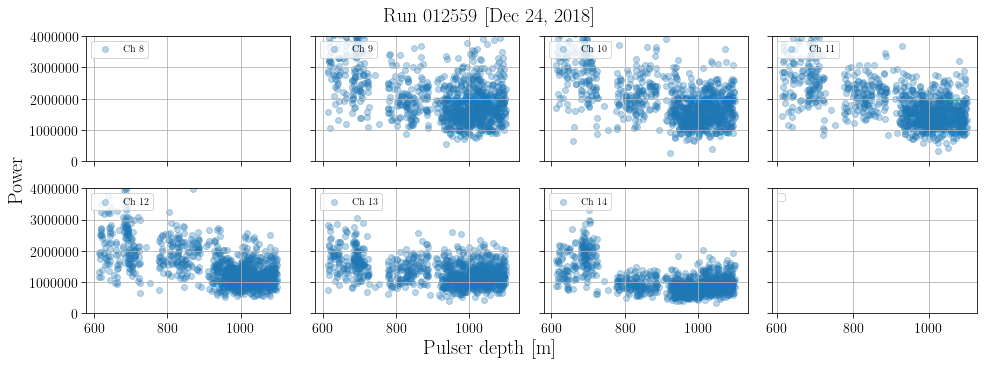

In [43]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
    axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
    ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
#     ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012611 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/PowervsDepth_run012611.png', dpi=250)


No handles with labels found to put in legend.


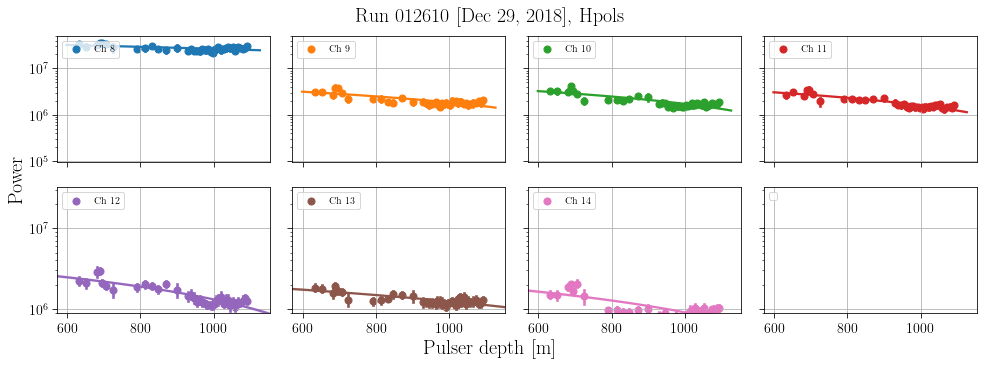

In [58]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
#     axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    sns.regplot(x=df.depth, y=df["%s"%a], x_bins=40, ax = axs[ch], label = "Ch %i"%(ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012611 [Dec 29, 2018], Hpols", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/HpolPowervsDepthProfile_run012611.png', dpi=250)


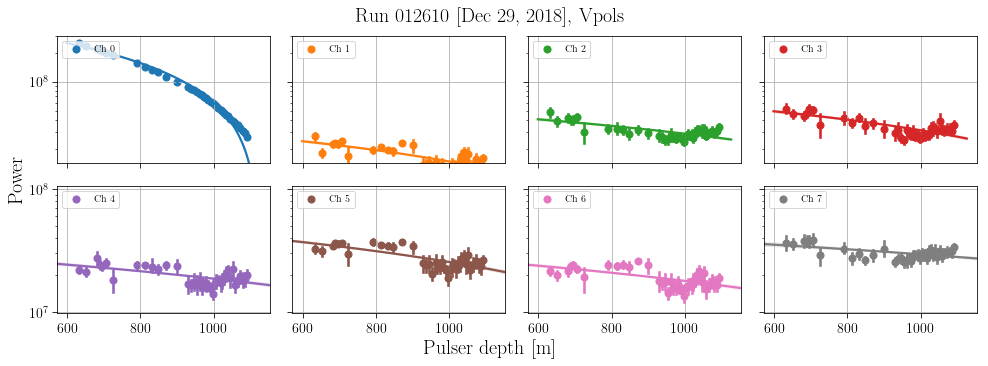

In [59]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:8], df.columns[8:]):
#     axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    sns.regplot(x=df.depth, y=df["%s"%a], x_bins=40, ax = axs[ch], label = "Ch %i"%(ch))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012611 [Dec 29, 2018], Vpols", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/VpolPowervsDepthProfile_run012611.png', dpi=250)


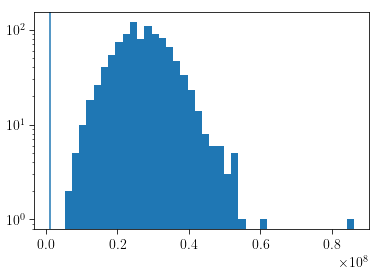

In [46]:
plt.hist(df.ch8Pow, bins = 40);
plt.axvline(noisePowerChan[8])
plt.yscale('log')

In [47]:
sub = df.ch8Pow-noisePowerChan[8]
len(sub[sub<0])/len(sub)

0.0

In [48]:
ch = 0
chs = []
frac = []
for a,b in zip(df.columns[:16], df.columns[:16]):
    sub = df["%s"%a]-noisePowerChan[ch]
    frac.append(len(sub[sub<0])/len(sub))
    chs.append(ch)
    ch+=1

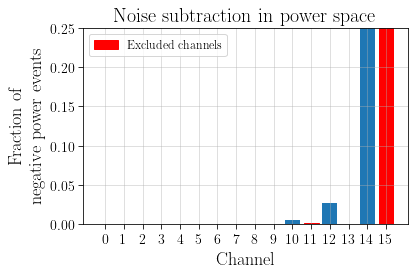

In [49]:
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4))
barlist = plt.bar(chs,frac)
barlist[9].set_color('r')
barlist[11].set_color('r')
barlist[15].set_color('r')

plt.xticks(np.arange(0, 16, step=1));
plt.grid(alpha = 0.5)
plt.xlabel("Channel")
plt.ylabel("Fraction of \n negative power events")
plt.title("Noise subtraction in power space")
plt.ylim(0,0.25)


red_patch = mpatches.Patch(color='red', label='Excluded channels')
plt.legend(handles=[red_patch])
plt.tight_layout()


In [50]:
def getPsi(R):
#     theta = np.radians(theta)
#     phi = np.radians(phi)
#     numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
#     denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    return np.degrees(np.arctan(R))

def getOmega(theta, R):
    theta = np.radians(theta)
    numerator = np.sin(theta)
    denominator = np.sqrt(1+R**2)
    return np.degrees(np.arccos(numerator/denominator))

def getR(powH, powH_noise, powV, powV_noise, chi):
    Rmeas = np.sqrt((powH-powH_noise)/(powV-powV_noise))
    return np.sqrt((1-chi)*Rmeas**2-chi)

In [51]:
def find68Perc(x,y):
    for bins in range(len(y)):
        integral = sum(y[:bins])*(x[1]-x[0])
        if(integral>0.68):
            break
    return x[bins]

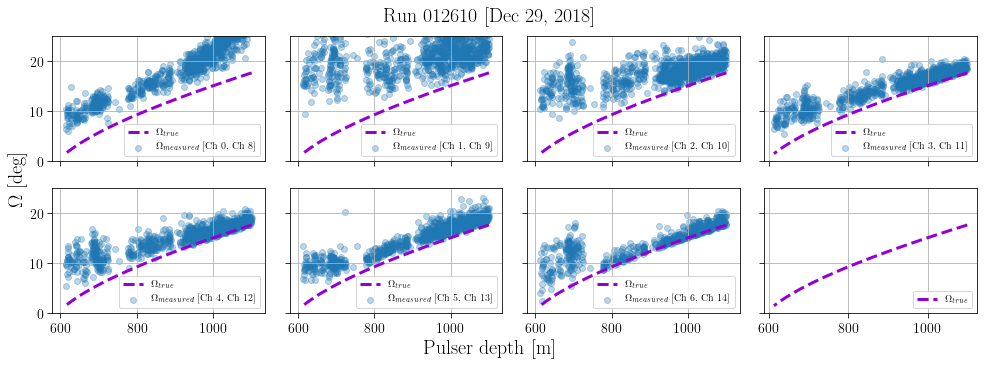

In [60]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],1,df["%s"%a]/noisePowerChan[ch],1,0.)
    values = getOmega(df.rec_ang, R)
    pol = getOmega(df.rec_ang,0)
    axs[ch].scatter(df.depth, values, alpha = 0.3, label = "$\Omega_{measured}$ [Ch %i, Ch %i]"%(ch,ch+8))

    ch+=1
for ax in axs:
    ax.set_ylim(0,25)
    ax.set(xlabel="", ylabel = "")
    ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()

    ax.legend(loc="lower right", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012611 [Dec 29, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmega_Amymethod_run012611.png', dpi=250)


No handles with labels found to put in legend.


2.6508371263081605
[4.3770875]
4.478136942924217
[5.94180766]
3.241680775270567
[1.88892998]
1.7852606943697942
[1.01785157]
2.3205403574619914
[1.20435752]
1.6479999677938713
[1.43320466]
2.852753134182159
[0.00061591]


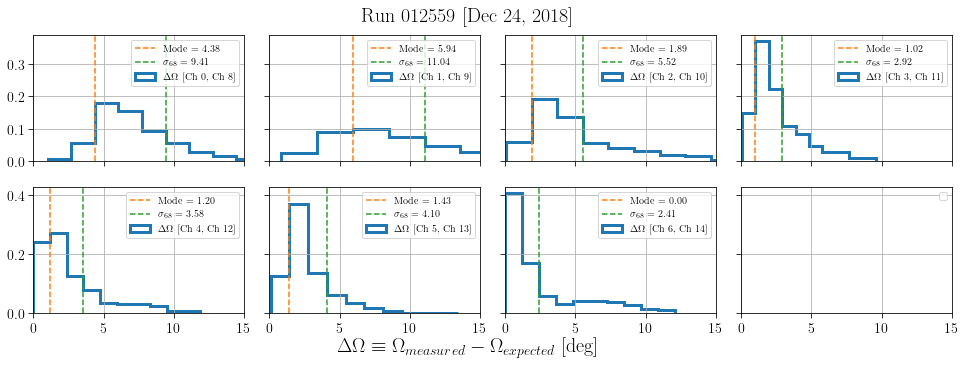

In [52]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],1,df["%s"%a]/noisePowerChan[ch],1,0.)
    values = getOmega(df.rec_ang, R)
    pol = getOmega(df.rec_ang,0)
    delta = values[~np.isnan(values)]-pol[~np.isnan(values)]
    y, x, _ = axs[ch].hist(delta,label = "$\Delta\Omega$ [Ch %i, Ch %i]"%(ch,ch+8), bins = 10, histtype='step', stacked=True, fill=False, lw = 3, density = True);
    mode = x[np.where(y == y.max())]
    axs[ch].axvline(mode, ls="--", color = "C1", label = "Mode = %0.2f"%mode)
    Interval68Pct = find68Perc(x,y)
    axs[ch].axvline(Interval68Pct, ls="--", color = "C2", label = "$\sigma_{68}$ = %0.2f"%Interval68Pct)

    ch+=1
    print(delta.std())
    print(x[np.where(y == y.max())])
for ax in axs:
    ax.set_xlim(0,15)
#     ax.set_ylim(0,30)
    ax.set(xlabel="", ylabel = "")
    ax.grid()

    ax.legend(loc="upper right", fontsize=10)

fig.text(0.5, 0.03, '$\Delta\Omega \equiv \Omega_{measured}-\Omega_{expected}$ [deg]', ha='center', va='center', fontsize=20) 
# fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012611 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmega_Amymethod_run012559.png', dpi=250)
